In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyvi
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 3.8 MB/s 
     |████████████████████████████████| 965 kB 53.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_files
from pyvi import ViTokenizer
import numpy as np 
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

SEED = 19

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/NLP-Project/dataset/train_dataset.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP-Project/dataset/test_dataset.csv")

In [ ]:
X_train, X_test, Y_train, Y_test = train_df.text, test_df.text, train_df.label_id, test_df.label_id

In [ ]:
label_train, freq_train = np.unique(Y_train, return_counts=True)

<BarContainer object of 8 artists>

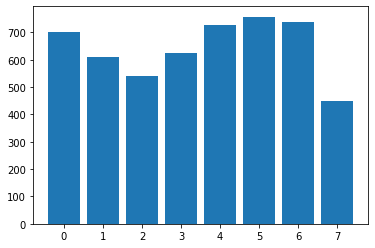

In [ ]:
plt.bar(label_train, freq_train)

In [ ]:
label_test, freq_test = np.unique(Y_test, return_counts=True)

<BarContainer object of 8 artists>

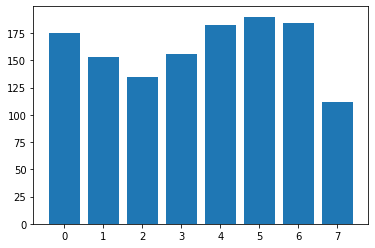

In [ ]:
plt.bar(label_test, freq_test)

In [ ]:
import gensim
import os
import numpy as np
from sklearn.model_selection import train_test_split 
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel


class LDA():
    def __init__(self, num_topics=5, chunksize=256, alpha=0.1, eta=0.1, iterations=100):
        self.ckpts_dir = "/content/drive/MyDrive/NLP-Project/LDA+ML/LDA_checkpoints"
        self.params = {'num_topics':num_topics, 'alpha':alpha, 'eta':eta, 'iterations':iterations}
        self.model = None

    def fit(self, X_train):
        self.X_train = X_train
        self.dictionary = Dictionary(text.split() for text in X_train)
        self.train_corpus = [self.dictionary.doc2bow(text.split()) for text in X_train] # (word_idx, freq_count)
        self.model = gensim.models.LdaMulticore(id2word=self.dictionary, minimum_probability=0.000, **self.params)
        self.model.update(self.train_corpus)
        return self

    def save(self, model_name='test'):
        os.makedirs(os.path.join(self.ckpts_dir, model_name), exist_ok=True)
        self.model.save(os.path.join(self.ckpts_dir, model_name, model_name))
    
    def load(self, model_name='test'):
        self.model = gensim.models.LdaMulticore.load(os.path.join(self.ckpts_dir, model_name, model_name))
        self.dictionary = self.model.id2word
        

    def predict(self, document:str):
        document = document.split()
        document = self.dictionary.doc2bow(document)
        
        topics =  self.model.get_document_topics(document)
        result = []
        for topic in topics:
            result.append(topic[1])
        return np.array(result)
    
    def score(self, *args, **kwargs):
        score_fn = CoherenceModel(model=self.model, texts=[text.split() for text in self.X_train], dictionary=self.dictionary, coherence='c_v')
        return score_fn.get_coherence()
    
    def get_params(self, deep=False):
        return self.params
    
    def set_params(self, **parameters):
        self.params = parameters
        return self

In [ ]:
extractor = LDA(**{'num_topics':50, 'alpha':1.1, 'eta':0.5, 'iterations':1000})
extractor.fit(X_train)

In [ ]:
extractor.score()

0.296246727127026

In [ ]:
X_train_features = [extractor.predict(x) for x in X_train]
X_test_features = [extractor.predict(x) for x in X_test]

In [ ]:
from sklearn.svm import SVC
classifier_1 = SVC()
from sklearn.model_selection import GridSearchCV

SVC_params = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1.0, 5.0, 10.0]}
selector = GridSearchCV(classifier_1, SVC_params, scoring='f1_macro')
selector.fit(X_train_features, Y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 5.0, 10.0],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='f1_macro')

In [ ]:
classifier_1 = selector.best_estimator_

In [ ]:
selector.best_params_

{'C': 10.0, 'kernel': 'rbf'}

In [ ]:
Y_pred = classifier_1.predict(X_test_features)
precision_recall_fscore_support(Y_test, Y_pred)

(array([0.7752809 , 0.57763975, 0.78625954, 0.84868421, 0.8125    ,
        0.91111111, 0.82989691, 0.89565217]),
 array([0.78857143, 0.60784314, 0.76296296, 0.82692308, 0.78571429,
        0.86315789, 0.875     , 0.91964286]),
 array([0.78186969, 0.59235669, 0.77443609, 0.83766234, 0.79888268,
        0.88648649, 0.85185185, 0.90748899]),
 array([175, 153, 135, 156, 182, 190, 184, 112]))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier_2 = RandomForestClassifier()
RF_params = {'n_estimators':[300, 400, 450, 500, 550], 'criterion':['gini'], 'random_state':[SEED], 'max_depth':[17, 20, 22, 25, 27, 30],'max_features':['log2', 'sqrt']}
selector_2 = GridSearchCV(classifier_2, RF_params, scoring='f1_macro')
selector_2.fit(X_train_features, Y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'],
                         'max_depth': [17, 20, 22, 25, 27, 30],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [300, 400, 450, 500, 550],
                         'random_state': [19]},
             scoring='f1_macro')

In [ ]:
selector_2.best_params_

{'criterion': 'gini',
 'max_depth': 22,
 'max_features': 'log2',
 'n_estimators': 550,
 'random_state': 19}

In [ ]:
classifier_2 = selector_2.best_estimator_

In [ ]:
Y_pred_2 = classifier_2.predict(X_test_features)
precision_recall_fscore_support(Y_test, Y_pred_2)[2].mean()

0.8265327326700633

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

base_estimator = DecisionTreeClassifier(max_depth=18, max_features='log2', random_state=SEED, min_samples_leaf=5)
classifier_3 = AdaBoostClassifier(base_estimator=base_estimator, random_state=SEED, algorithm='SAMME.R')
Ada_params = {'n_estimators':[650, 700], 'learning_rate':[0.001]}
selector_3 = GridSearchCV(classifier_3, Ada_params, scoring='f1_macro')
selector_3.fit(X_train_features, Y_train)

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=18,
                                                                                max_features='log2',
                                                                                min_samples_leaf=5,
                                                                                random_state=19),
                                          random_state=19),
             param_grid={'learning_rate': [0.001], 'n_estimators': [650, 700]},
             scoring='f1_macro')

In [ ]:
selector_3.best_score_

0.8077460500645632

In [ ]:
classifier_3 = selector_3.best_estimator_

In [ ]:
Y_pred_3 = classifier_3.predict(X_test_features)
precision_recall_fscore_support(Y_test, Y_pred_3)[2].mean()

0.8151114352985365

In [ ]:
Y_test[4]

4